In [1]:
import wikipedia as wiki
from collections import defaultdict, Counter 
import re
import heapq

from sentence_transformers import SentenceTransformer
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import numpy as np

from tqdm import tqdm
import urllib

from requests_html import HTMLSession
import requests
from bs4 import BeautifulSoup
import html_text

import nltk
from os.path import isfile, join

from sklearn.metrics.pairwise import cosine_similarity

import networkx as nx

from transformers import pipeline
from nltk.tokenize import word_tokenize

In [2]:
def clean_title(title):
    return title[:-1].lower() if title[-1] == 's' else title.lower()

In [3]:
TITLE = clean_title("computer architecture")
SUBSECTIONS = 4
RELATED_TITLES = wiki.search(TITLE)

In [4]:
RELATED_TITLES

['Computer architecture',
 'Word (computer architecture)',
 'Hazard (computer architecture)',
 'Von Neumann architecture',
 'Multithreading (computer architecture)',
 'Predication (computer architecture)',
 'Computer',
 'Microarchitecture',
 'Computer science',
 'Computer architecture simulator']

In [5]:
def get_subsections(data, raw=False):
    subsections = re.findall('\n== ([a-zA-z ]+) ==', data)
    subsections = [subsection.lower() for subsection in subsections]
    if raw:
        return subsections
    subsections = re.findall('\n== ([a-zA-z]+) ==', data)
    subsections = [subsection.lower() for subsection in subsections]
    if "references" in subsections:
        subsections.remove("references")
    if "see also" in subsections:
        subsections.remove("see also")
    if "external link" in subsections:
        subsections.remove("external link")
    if "note" in subsections:
        subsections.remove("note")
    subsections = [subsection[:-1].lower() if subsection[-1] == 's' else subsection.lower() \
                   for subsection in subsections]
    return subsections

In [6]:
def get_important_subsections_and_content(related_titles):
    topics = []
    related_paper_section_content = defaultdict(list)
    for related_title in related_titles:
        try:
            related_page = wiki.WikipediaPage(title=related_title)
        except wiki.DisambiguationError as e:
            continue

        content = (related_page.content).lower()
        subsections = get_subsections(content, raw=True)
        topics.extend(get_subsections(content))
        delimiters = ''
        for subsection in subsections:
            delimiters += '== ' + str(subsection) + ' ==|'
        delimiters = delimiters[:-1]
        words = re.split(delimiters, content)
        words = [word.replace('\n', '') for word in words]
        related_paper_section_content['intro'].append(str(words[0]))
        for i, subsection in enumerate(subsections):
            if subsection[-1] == 's':
                subsection = subsection[:-1]
            related_paper_section_content[subsection].append(str(words[i+1]))

    common_subsections = Counter(topics)
    important_subsections = heapq.nlargest(SUBSECTIONS, common_subsections, key=common_subsections.__getitem__)
    return important_subsections, related_paper_section_content

In [7]:
# run related_paper_section_content separately
important_subsections, related_paper_section_content = get_important_subsections_and_content(RELATED_TITLES)
important_subsections.insert(0, 'intro')

In [8]:
important_subsections

['intro', 'history', 'note', 'source', 'type']

In [9]:
related_paper_section_content.keys()

dict_keys(['intro', 'history', 'subcategorie', 'role', 'design goal', 'see also', 'reference', 'source', 'external link', 'uses of word', 'word size choice', 'size familie', 'table of word size', 'note', 'background', 'type', 'eliminating hazard', 'capabilitie', 'evolution', 'design limitation', 'further reading', 'overview', 'types of multithreading', 'implementation specific', 'advantage', 'disadvantage', 'etymology', 'hardware', 'software', 'networking and the internet', 'unconventional computer', 'future', 'professions and organization', 'relation to instruction set architecture', 'aspect', 'microarchitectural concept', 'philosophy', 'field', 'discoverie', 'programming paradigm', 'academia', 'education', 'categorie'])

In [10]:
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

In [11]:
topic_embeddings = defaultdict(list)

In [12]:
for subsections in tqdm(important_subsections):
    paras = related_paper_section_content[subsections]
    print("subsection: ", subsections)
    print("paras: ", len(paras))

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 24244.53it/s]

subsection:  intro
paras:  10
subsection:  history
paras:  5
subsection:  note
paras:  3
subsection:  source
paras:  2
subsection:  type
paras:  2


In [12]:
features = []
for subsections in tqdm(important_subsections):
    paras = related_paper_section_content[subsections]
    topic_emb = np.average(model.encode(paras), 0)
    features.append(topic_emb)
    topic_embeddings[subsections] = topic_emb

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


In [13]:
topic_embeddings

defaultdict(list,
            {'intro': array([-0.02086659, -0.0058955 , -0.00109885, ..., -0.0145632 ,
                    -0.01239052,  0.0055468 ], dtype=float32),
             'history': array([-0.00404927, -0.00525444,  0.01348941, ..., -0.00970294,
                     0.00595382,  0.00850121], dtype=float32),
             'note': array([-0.01981773, -0.00571731,  0.02226208, ...,  0.01589679,
                     0.00024185,  0.01825439], dtype=float32),
             'source': array([-0.01102131, -0.01338195,  0.00431949, ...,  0.0093503 ,
                    -0.0110891 ,  0.0082404 ], dtype=float32),
             'type': array([ 0.02489298, -0.00868176, -0.01139156, ...,  0.02240594,
                     0.01339936,  0.03120553], dtype=float32)})

In [14]:
def get_source(url):
    try:
        session = HTMLSession()
        response = session.get(url)
        return response
    except requests.exceptions.RequestException as e:
        print(e)
        
def scrape_google(query):
    query = urllib.parse.quote_plus(query)
    response = get_source("https://www.google.com/search?q=" + query)
    links = list(set(response.html.absolute_links))
    google_domains = ('https://www.google.', 
                      'https://google.',
                      'https://www.google.com/search?',
                      'https://webcache.googleusercontent.', 
                      'http://webcache.googleusercontent.', 
                      'https://policies.google.',
                      'https://support.google.',
                      'https://maps.google.',
                      'https://www.coursera.org',
                      'https://www.youtube.com',
                     'https://online.umich.edu/',
                      'https://docs.oracle.com/',
                      'https://www.cise.ufl.edu/~mssz/CompOrg/CDA-lang.html',
                      'https://study.com/academy',
                      'https://www.redhat.com',
                      'https://www.oreilly.com',
                      'https://scholar.google.com',
                      'https://machinelearningknowledge',
                      'https://interestingengineering.com',
                      'https://www.nature.com/',
                      'https://machinelearningmastery.com',
                      'https://www.thelancet.com/',
                      'https://m.youtube.com',
                      'https://www.mathworks.com',
                      'https://www.deeplearningbook'
                     )
    
    for url in links[:]:
        url_check = url.split('#')[0]
        if url_check in urls_visited or url.startswith(google_domains):
            links.remove(url)
        if url_check not in urls_visited:
            urls_visited.add(url_check)
        if url[-3:] == 'pdf':
            links.remove(url)
    return links


def google_search(query):
    response = scrape_google(query)
    return response

In [15]:
def collect_data_from_url(results):
    data = []
    for url in results:
        print(url)
        if url.startswith('http://en.wikipedia.org/wiki/') or url.startswith('https://en.wikipedia.org/wiki/'):
            search_term = url.replace('http://en.wikipedia.org/wiki/', '').replace('https://en.wikipedia.org/wiki/', '').replace('_', ' ').replace('%E2%80%93', '-').replace('%27', "'")
            sentences = wiki.WikipediaPage(title=search_term).content
            text_info = ''
            for sent in sentences.split('.'):
                if sent == '' or len(sent) > 500 or len(sent) < 10:
                    continue
                sent_emb = torch.from_numpy(model.encode(sent))
                if float(sent_emb @ topic_emb) < 0.3:
                    continue
                text_info += (sent + '. ')

            item = {
                'title': search_term,
                'link': url,
                'text': text_info,
                #'emb': model.encode(text_info)
            }
            data.append(item) 
        else:
            try: 
                page = requests.get(url, timeout=(5, 10))
            except requests.exceptions.Timeout as err: 
                #print("here")
                continue
            #print(page)
            soup = BeautifulSoup(page.content, "html.parser",from_encoding="iso-8859-1")
            p = soup.find_all('p')
            paragraphs = []
            for x in p:
                paragraphs.append(str(x))
            if len(paragraphs) == 0:
                continue
            text_info = ''
            for para in paragraphs:
                if para == '':
                    continue
                sentences = html_text.extract_text(para, guess_layout=False)
                for sent in sentences.split('.'):
                    if sent == '' or len(sent) > 500 or len(sent) < 10:
                        continue
                    sent_emb = torch.from_numpy(model.encode(sent))
                    if float(sent_emb @ topic_emb) < 0.3:
                        continue
                    text_info += (sent + '. ')
            if len(text_info) < 100 or len(text_info) > 10000: 
                continue
            item = {
                'title': "<UNK>",
                'link': url,
                'text': text_info,
                #'emb': model.encode(text_info)
            }
            data.append(item)
    return data

In [16]:
urls_visited = set()
results = []
for text in important_subsections:
    if text == 'intro':
        results.extend(google_search("what is " + TITLE))
    else:
        results.extend(google_search(TITLE + " " + text.lower()))
results

['https://en.wikipedia.org/wiki/Category:Computer_architecture',
 'https://www.computersciencedegreehub.com/faq/what-is-computer-architecture/',
 'https://online.sunderland.ac.uk/what-is-computer-architecture/',
 'https://geteducationskills.com/computer-architecture/',
 'https://www.techopedia.com/definition/26757/computer-architecture',
 'https://en.wikipedia.org/wiki/Microarchitecture',
 'https://www.britannica.com/technology/computer-architecture',
 'https://www.sciencedirect.com/topics/computer-science/computer-architecture',
 'https://en.wikipedia.org/wiki/Word_(computer_architecture)',
 'https://www.educba.com/types-of-computer-architecture/',
 'https://en.wikipedia.org/wiki/Computer_architecture',
 'https://www.tutorialspoint.com/what-is-computer-architecture',
 'https://www.sigarch.org/a-brief-and-biased-history-of-computer-architecture-part-1/',
 'https://dl.acm.org/doi/10.1109/MAHC.1988.10039',
 'https://www.computer.org/csdl/magazine/an/1988/04/man1988040277/13rRUxZRbrm',
 '

In [17]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
raw_dataset = defaultdict(list)
cleaned_para = []

for result in results:
    temp_dataset = ''
    paragraphs = []
    temp_cleaned_para = []
    try:
        page = requests.get(result, timeout=(5, 10), headers=headers)
    except:
        print("here")
        continue
    soup = BeautifulSoup(page.content, "html.parser")
    p = soup.find_all('p')
    
    
    for x in p:
        paragraphs.append(str(x))
    for i, para in enumerate(paragraphs):
        if para != '':
            temp_cleaned_para.append(html_text.extract_text(para, guess_layout=False))

    for i, para in enumerate(temp_cleaned_para):
        if len(nltk.word_tokenize(para)) > 30 and len(nltk.word_tokenize(para)) < 150:
            para = re.sub('[\[].*?[\]]', '', para)
            raw_dataset[result].append(para)
            cleaned_para.append(para)
    
    print(result, len(p))
len(cleaned_para)

https://en.wikipedia.org/wiki/Category:Computer_architecture 2
https://www.computersciencedegreehub.com/faq/what-is-computer-architecture/ 9
https://online.sunderland.ac.uk/what-is-computer-architecture/ 22
https://geteducationskills.com/computer-architecture/ 22
https://www.techopedia.com/definition/26757/computer-architecture 22
https://en.wikipedia.org/wiki/Microarchitecture 40
https://www.britannica.com/technology/computer-architecture 3
https://www.sciencedirect.com/topics/computer-science/computer-architecture 4
https://en.wikipedia.org/wiki/Word_(computer_architecture) 27
https://www.educba.com/types-of-computer-architecture/ 51
https://en.wikipedia.org/wiki/Computer_architecture 32
https://www.tutorialspoint.com/what-is-computer-architecture 19
https://www.sigarch.org/a-brief-and-biased-history-of-computer-architecture-part-1/ 18
https://dl.acm.org/doi/10.1109/MAHC.1988.10039 27
https://www.computer.org/csdl/magazine/an/1988/04/man1988040277/13rRUxZRbrm 0
https://edurev.in/stud

348

In [18]:
paragraph_reference = {}
for key, val in raw_dataset.items():
    for v in val:
        paragraph_reference[v] = key

In [19]:
paragraph_reference

{'Although the term computer architecture sounds very complicated, its definition is easier than one might think. Computer architecture is a science or a set of rules stating how computer software and hardware are joined together and interact to make a computer work. It not only determines how the computer works but also of which technologies the computer is capable. Computers continue to be a major part of our lives, and computer architects continue to develop new and better programs and technologies.': 'https://www.computersciencedegreehub.com/faq/what-is-computer-architecture/',
 'Computer architecture is a specification describing how hardware and software technologies interact to create a computer platform or system. When we think of the word architecture, we think of building a house or a building. Keeping that same principle in mind, computer architecture involves building a computer and all that goes into a computer system. Computer architecture consists of three main categorie

In [20]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
link_2_title = {}

raw_dataset = defaultdict(str)

for result in results:
    temp_dataset = ''
    paragraphs = []
    temp_cleaned_para = []
    try:
        page = requests.get(result, timeout=(5, 10), headers=headers)
    except:
        continue
    soup = BeautifulSoup(page.content, "html.parser")
    p = soup.find_all('p')
    title = str(soup.find('title'))
    link_2_title[result] = html_text.extract_text(title)
    
    for x in p:
        paragraphs.append(str(x))
    for i, para in enumerate(paragraphs):
        if para != '':
            temp_cleaned_para.append(html_text.extract_text(para, guess_layout=False))

    for i, para in enumerate(temp_cleaned_para):
        if len(nltk.word_tokenize(para)) > 30 and len(nltk.word_tokenize(para)) < 150:
            para = re.sub('[\[].*?[\]]', '', para)
            cleaned_para.append(para)
            temp_dataset += para
            
    raw_dataset[result] = temp_dataset

In [21]:
link_2_title

{'https://en.wikipedia.org/wiki/Category:Computer_architecture': 'Category:Computer architecture - Wikipedia',
 'https://www.computersciencedegreehub.com/faq/what-is-computer-architecture/': 'What is Computer Architecture? - Computer Science Degree Hub',
 'https://online.sunderland.ac.uk/what-is-computer-architecture/': 'What is computer architecture? - University of Sunderland',
 'https://geteducationskills.com/computer-architecture/': 'What Is Computer Architecture? – Get Education',
 'https://www.techopedia.com/definition/26757/computer-architecture': 'What is Computer Architecture? - Definition from Techopedia',
 'https://en.wikipedia.org/wiki/Microarchitecture': 'Microarchitecture - Wikipedia',
 'https://www.britannica.com/technology/computer-architecture': 'computer architecture | Definition & Facts | Britannica',
 'https://www.sciencedirect.com/topics/computer-science/computer-architecture': 'Just a moment...',
 'https://en.wikipedia.org/wiki/Word_(computer_architecture)': 'Word

In [22]:
mypath = "/Users/arpan/Documents/FORWARD_LAB"
word_embeddings = {}
f = open(join(mypath, 'glove.6B.300d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [23]:
website_vectors = []
webside_embeddings = {}
for key, val in raw_dataset.items():
    if len(val) != 0:
        v = sum([word_embeddings.get(w, np.zeros((300,))) for w in val.split()])/(len(val.split())+0.001)
    else:
        v = np.zeros((300,))
    webside_embeddings[key] = v
    website_vectors.append(v)

In [24]:
len(website_vectors)

39

In [25]:
sim_mat = np.zeros([len(website_vectors), len(website_vectors)])

In [26]:
for i in range(len(website_vectors)):
    for j in range(len(website_vectors)):
        if i != j:
            sim_mat[i][j] = cosine_similarity\
            (website_vectors[i].reshape(1,300), \
             website_vectors[j].reshape(1,300))[0,0]

In [27]:
sim_mat

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.98459789, ..., 0.90930794, 0.        ,
        0.        ],
       [0.        , 0.98459789, 0.        , ..., 0.91273369, 0.        ,
        0.        ],
       ...,
       [0.        , 0.90930794, 0.91273369, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [28]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [29]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(raw_dataset.keys())), reverse=True)

In [30]:
cleaned_para = list(set(cleaned_para))

In [31]:
len(cleaned_para)

341

In [32]:
sentence_vectors = []
for i in cleaned_para:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((300,))
    sentence_vectors.append(v)

In [33]:
sim_mat = np.zeros([len(cleaned_para), len(cleaned_para)])

In [34]:
for i in range(len(cleaned_para)):
    for j in range(len(cleaned_para)):
        if i != j:
            sim_mat[i][j] = cosine_similarity\
            (sentence_vectors[i].reshape(1,300), \
             sentence_vectors[j].reshape(1,300))[0,0]

In [35]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [36]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(cleaned_para)), reverse=True)[:100]

In [37]:
paragraphs = []
for sent in cleaned_para:
    for _, sentence in ranked_sentences:
        if sent == sentence:
            paragraphs.append(sent)

In [38]:
len(paragraphs)

100

In [39]:
paragraphs

['Electrically Erasable Programmable ROM (EEPROM): The next level of erasability is the EEPROM, which can be erased under software control. This is the most flexible type of ROM, and is now commonly used for holding BIOS programs. When you hear reference to a "flash BIOS" or doing a BIOS upgrade by "flashing", this refers to reprogramming the BIOS EEPROM with a special software program. Here we are blurring the line a bit between what "read-only" really means, but remember that this rewriting is done maybe once a year or so,',
 'Different amounts of memory are used to store data values with different degrees of precision. The commonly used sizes are usually a power of two multiple of the unit of address resolution (byte or word). Converting the index of an item in an array into the memory address offset of the item then requires only a shift operation rather than a multiplication. In some cases this relationship can also avoid the use of division operations. As a result, most modern co

In [40]:
dataset = defaultdict(list)
label = []
for sentence in tqdm(paragraphs):
    temp = []
    for i in features:
        temp.append(float(cosine_similarity([i], [model.encode(sentence)])[0][0]))
    label.append(important_subsections[np.argmax(temp)])
    dataset[important_subsections[np.argmax(temp)]].append(sentence)

100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


In [41]:
for k, v in dataset.items():
    print(len(v))

12
74
14


In [42]:
dataset.keys()

dict_keys(['type', 'intro', 'history'])

In [43]:
embs = []

for sentence in tqdm(paragraphs):
    embs.append(model.encode(sentence))

100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
x = pca.fit_transform(embs)[:,0]
y = pca.fit_transform(embs)[:,1]

In [45]:
import seaborn as sns

<AxesSubplot:>

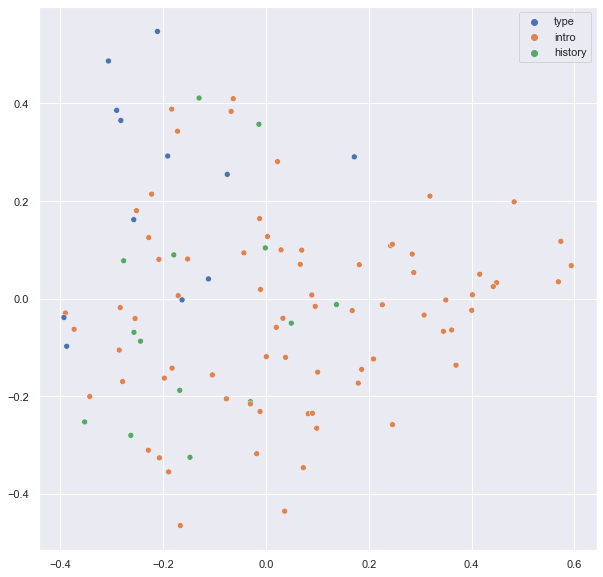

In [46]:
sns.set(style="darkgrid", rc = {'figure.figsize':(10,10)})
sns.scatterplot(x=x, y=y, hue=label, palette="deep")

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
x = pca.fit_transform(features)[:,0]
y = pca.fit_transform(features)[:,1]

In [48]:
import seaborn as sns

<AxesSubplot:>

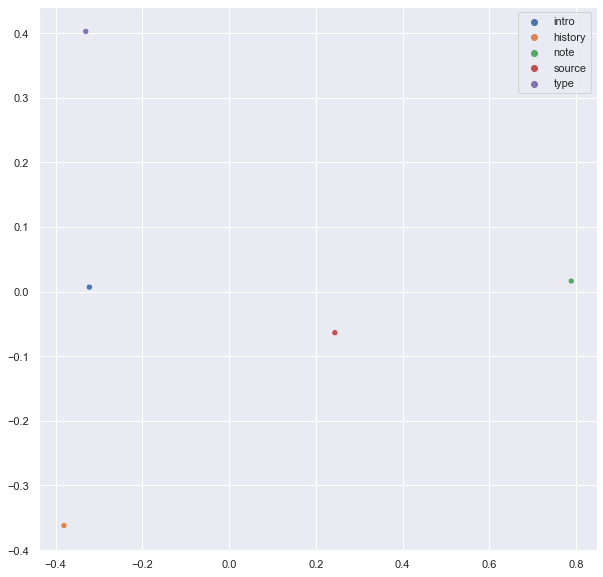

In [49]:
sns.set(style="darkgrid", rc = {'figure.figsize':(10,10)})
sns.scatterplot(x=x, y=y, hue=important_subsections, palette="deep")

In [50]:
bad_paras = []
with open('../notebooks/bad_sentences.txt') as f:
    for line in f:
        bad_paras.append(line[:-1])
bad_emb = torch.from_numpy(model.encode(bad_paras))

In [51]:
dataset_clean = defaultdict(list)
for section in important_subsections:
    for paras in dataset[section]:
        prag_emb = torch.from_numpy(model.encode(paras))
        if torch.max(prag_emb @ bad_emb.T) < 0.5 and paras != '':
            dataset_clean[section].append(paras)
        else:
            print(torch.max(prag_emb @ bad_emb.T), prag_emb, paras)

tensor(0.5057) tensor([-0.0223, -0.0101, -0.0047,  ..., -0.0330, -0.0543,  0.0088]) Although the term computer architecture sounds very complicated, its definition is easier than one might think. Computer architecture is a science or a set of rules stating how computer software and hardware are joined together and interact to make a computer work. It not only determines how the computer works but also of which technologies the computer is capable. Computers continue to be a major part of our lives, and computer architects continue to develop new and better programs and technologies.
tensor(0.5132) tensor([-0.0262,  0.0024, -0.0032,  ..., -0.0153, -0.0432,  0.0054]) A Brief History of Computer Architecture Computer Architecture is the field of study of selecting and interconnecting hardware components to create computers that satisfy functional performance and cost goals. It refers to those attributes of the computer system that are visible to a programmer and have a direct effect on th

In [52]:
summarizer = pipeline('summarization', model="sshleifer/distilbart-cnn-12-6" )

In [53]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [54]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [56]:
final_summary = defaultdict(list)
references = defaultdict(list)
for i, subsection in tqdm(enumerate(important_subsections)):
    text = dataset_clean[subsection]
    if text == []:
        continue
        
    num_paras = len(text)
    if num_paras > 5:
        groups = chunkIt(text, num_paras//5)
        #print(len(groups))
        
        for group in groups:
            ref = []
            for sentence in group:
                ref.append(paragraph_reference[sentence])
            references[subsection].append(ref)
            data = ''.join(group)
            #print(len(tokenizer([data])['input_ids'][0]))
            if len(tokenizer([data])['input_ids'][0]) > 1023:
                count = 0
                data_nlp = nlp(data)
                sentences = list(data_nlp.sents)
                #print(sentences)
                data = ""
                for sentence in sentences:
                    sentence = str(sentence)
                    #print(type(sentence))
                    count += (2 + len(word_tokenize(sentence)))
                    if count < 924:
                        data += sentence
            #print(len(tokenizer([data])['input_ids'][0]))
            
            summary_text = summarizer(data, max_length=len(word_tokenize(data))//2, \
                              min_length = len(word_tokenize(data))//4)[0]['summary_text']
            summary_text = summary_text.replace(u'\xa0', u' ')
            final_summary[subsection].append(summary_text)
    else:
        data = ''.join(text)
        summary_text = summarizer(data, max_length=len(word_tokenize(data))//2, \
                          min_length = len(word_tokenize(data))//4)[0]['summary_text']
        summary_text = summary_text.replace(u'\xa0', u' ')
        final_summary[subsection].append(summary_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 512). Running this sequence through the model will result in indexing errors


In [57]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US') 
for key, val in final_summary.items():
    for i in range(len(val)):
        val[i] = tool.correct(val[i])
tool.close()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [58]:
final_summary.keys()

dict_keys(['intro', 'history', 'type'])

In [59]:
final_summary

defaultdict(list,
            {'intro': [' Different amounts of memory are used to store data values with different degrees of precision. The commonly used sizes are usually a power of two multiple of the unit of address resolution (byte or word) Converting index of an item in an array into the memory address offset of the item then requires only a shift operation rather than a multiplication. In some cases this relationship can also avoid the use of division operations. Most modern computer designs have word sizes (and other operand sizes) that are two times the size of a byte. An ISA specifies the behavior of machine code running on implementations of that ISA in a fashion that does not depend on the characteristics of that implementation. This enables multiple implementations of an ISA that differ in characteristics such',
              ' Computer architecture is the organization of the components which make up a computer system. It defines what is seen on the machine interface, whi

In [60]:
# topics selection - intro, syntax, feature, history

# intro - 5 pars -> 3 webstes

In [61]:



# INTRO

# website 1 url
# website 1 title

# (2 paras ralated to intro) -> summarize this in a few sentences


# website 2 url
# website 2 title

# (1 paras ralated to intro) -> summarize this in a few sentences

# website 3 url
# website 3 title

# (12 paras ralated to intro) -> summarize this in a few sentences



# HISTORY

# website 1 url
# website 1 title




# ARTICLE










